# Dogs vs Cats

kaggle 데이터셋을 이용한 개, 고양이 구분하기  
캐글 링크 : [Distinguish images of dogs from cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import output

In [3]:
!mkdir "./trainset"
!unzip "/content/drive/MyDrive/Data/catsdogs/train.zip" -d "./trainset/"
output.clear()

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob 
import os,cv2,random

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
path = './trainset/train/'
classes = ['dog', 'cat']

In [7]:
# Used for resize
ROW, COL = 96,96

dogs, cats = [],[]
y_dogs, y_cats = [],[]

In [8]:
# Definition to load all cats / dogs images

def load_dogs():
    print('Loading all dog images\n')
    dog_path = os.path.join(path, 'dog*')
    for dog_img in glob(dog_path):
        dog = cv2.imread(dog_img)
        dog = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
        dog = cv2.resize(dog, (ROW, COL))
        dog = image.img_to_array(dog)
        dogs.append(dog)
    print('All dog images loaded')

def load_cats():
    print('Loading all cat images\n')
    cat_path = os.path.join(path, 'cat*')
    for cat_img in glob(cat_path):
        cat = cv2.imread(cat_img)
        cat = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
        cat = cv2.resize(cat, (ROW, COL))
        cat = image.img_to_array(cat)
        cats.append(cat)
    print('All cat images loaded')

In [9]:
load_dogs()

Loading all dog images

All dog images loaded


In [10]:
load_cats()

Loading all cat images

All cat images loaded


In [11]:
y_dogs = [1 for item in enumerate(dogs)]
y_cats = [0 for item in enumerate(cats)]

In [12]:
# Converting everything to numpy to fit in our model
# Creating a X and target file like we used to see in ML, DL models

dogs = np.asarray(dogs).astype('float32') / 255 # 정규화
cats = np.asarray(cats).astype('float32') / 255

y_dogs = np.asarray(y_dogs).astype('int32')
y_cats = np.asarray(y_cats).astype('int32')

In [13]:
X = np.concatenate((dogs, cats),axis=0)
y = np.concatenate((y_dogs,y_cats),axis=0)

하이퍼 파라미터 설정

In [14]:
IMG_CHANNEL = 1
BATCH_SIZE = 128
N_EPOCH = 30
VERBOSE = 2
VALIDAION_SPLIT = 0.2
OPTIM = Adam()
N_CLASSES = len(classes)

데이터 분할

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=seed
)

원핫 인코딩

In [16]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train,N_CLASSES )
Y_test = to_categorical(y_test,N_CLASSES )

모델 생성

In [17]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(ROW, COL, IMG_CHANNEL), activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.5),
    Dense(N_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0

In [18]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy', 
              optimizer=OPTIM, metrics=['accuracy'])

In [19]:
# to save checkpoint to use latter
modelpath = 'model/dogs_vs_cats_redux_checkpoint.h5'
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True, verbose=1)

 모델 학습

In [20]:
history = model.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                    validation_split=VALIDAION_SPLIT,
                    verbose=VERBOSE, callbacks=[checkpoint])

Epoch 1/30
125/125 - 24s - loss: 0.6863 - accuracy: 0.5627 - val_loss: 0.6450 - val_accuracy: 0.6022

Epoch 00001: val_loss improved from inf to 0.64501, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 2/30
125/125 - 21s - loss: 0.5845 - accuracy: 0.6911 - val_loss: 0.5572 - val_accuracy: 0.7210

Epoch 00002: val_loss improved from 0.64501 to 0.55723, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 3/30
125/125 - 21s - loss: 0.5313 - accuracy: 0.7318 - val_loss: 0.5259 - val_accuracy: 0.7320

Epoch 00003: val_loss improved from 0.55723 to 0.52594, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 4/30
125/125 - 21s - loss: 0.4938 - accuracy: 0.7626 - val_loss: 0.4699 - val_accuracy: 0.7753

Epoch 00004: val_loss improved from 0.52594 to 0.46994, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 5/30
125/125 - 21s - loss: 0.4510 - accuracy: 0.7885 - val_loss: 0.4466 - val_accuracy: 0.7933

Epoch 00005: val_loss improved from 0.46994 to 0.4

In [23]:
acc = model.evaluate(X_test, Y_test, verbose=2)[1]
print('MODEL ACCURACY: %.5f' % acc)

157/157 - 3s - loss: 0.7442 - accuracy: 0.8268
MODEL ACCURACY: 0.82680


In [25]:
from tensorflow.keras.models import load_model
best_model = load_model(modelpath)
acc = best_model.evaluate(X_test, Y_test, verbose=2)[1]
print('Best model accuracy: %.5f' % acc)

157/157 - 3s - loss: 0.4083 - accuracy: 0.8198
Best model accuracy: 0.81980


In [26]:
# 검증셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']

# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

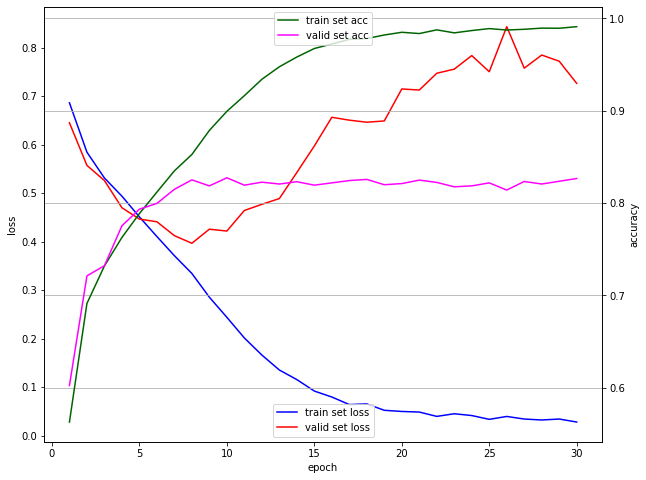

In [28]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='train set loss')
ax0.plot(x_len, y_vloss, c="red", label='valid set loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='train set acc')
ax1.plot(x_len, y_vacc, c="magenta", label='valid set acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()